In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/train.csv")
test = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/test.csv")
sample = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/sample_submission.csv")

In [ ]:
train.head()

In [ ]:
train.isnull().sum()

In [ ]:
duplicate_train = train[train.duplicated()]

In [ ]:
duplicate_train

In [ ]:
train.info()

In [ ]:
sns.distplot(train['age'])

In [3]:
object_col = []

for column in train.columns:
    if train[column].dtype == object and len(train[column].unique()) <=30:
        object_col.append (column)
        print (f"{column} : {train[column].unique()}")
        print (train[column].value_counts())
        print ("================")

department : ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64
education : ["Master's & above" "Bachelor's" nan 'Below Secondary']
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64
gender : ['f' 'm']
m    38496
f    16312
Name: gender, dtype: int64
recruitment_channel : ['sourcing' 'other' 'referred']
other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64


In [ ]:
train.isnull().sum()

In [4]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [5]:
train['education'] = train['education'].fillna("Bachelor's")

In [6]:
train['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [ ]:
sns.distplot(train['previous_year_rating'])

In [7]:
train['previous_year_rating'] = train['previous_year_rating'].fillna(3.0)

In [ ]:
train.head()

In [ ]:
test.isnull().sum()

In [8]:
test['education'] = test['education'].fillna("Bachelor's")
test['previous_year_rating'] = test['previous_year_rating'].fillna(3.0)

In [9]:
test['previous_year_rating'].value_counts()

3.0    9733
5.0    5097
4.0    4249
1.0    2680
2.0    1731
Name: previous_year_rating, dtype: int64

In [ ]:
sns.barplot(train['is_promoted'],train['is_promoted'].value_counts())

In [ ]:
train['is_promoted'].value_counts()

## Performing LGBM:

In [10]:
#train=train.drop_duplicates(subset=[ele for ele in list(train.columns) if ele not in ['employee_id']])

In [11]:
#train.shape

(54647, 14)

In [76]:
combine_set=pd.concat([train,test], ignore_index=True)

In [77]:
combine_set.shape

(78137, 14)

In [ ]:
combine_set.head()

In [13]:
le=LabelEncoder()

In [78]:
combine_set['gender']=le.fit_transform(combine_set['gender'])
combine_set['department']=le.fit_transform(combine_set['department'])
#combine_set['recruitment_channel']=le.fit_transform(combine_set['recruitment_channel'])

In [79]:
combine_set['education'].value_counts()

Bachelor's          55538
Master's & above    21424
Below Secondary      1175
Name: education, dtype: int64

In [80]:
combine_set['education']=combine_set['education'].map({'Below Secondary':0,"Bachelor's":1,"Master's & above":2})

In [ ]:
combine_set.tail()

In [81]:
combine_set[['region1','region']] =  combine_set['region'].str.split("_", expand = True)

In [82]:
combine_set.drop(['region1'], axis = 1, inplace = True)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(combine_set.corr(),annot=True,fmt=".2f")

In [83]:
combine_set['previous_year_rating'] = combine_set['previous_year_rating'].astype('int')

In [84]:
combine_set['departmentwise_rating']=combine_set.groupby(['department'])['previous_year_rating'].transform('mean')
combine_set['recruitment_rating']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('mean')

In [ ]:
combine_set.head()

In [85]:
combine_set['education_rating']=combine_set.groupby(['education'])['previous_year_rating'].transform('mean')

In [86]:
combine_set['awards_won_rating']=combine_set.groupby(['awards_won?'])['previous_year_rating'].transform('mean')

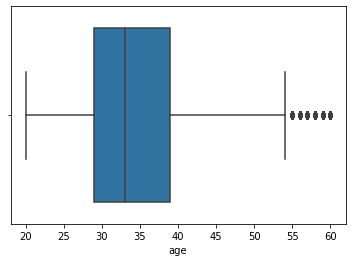

In [87]:
sns.boxplot(combine_set['age'])

In [88]:
combine_set['service_length_rating']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('mean')

In [89]:
combine_set['age_service_length_rating']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('mean')

In [ ]:
combine_set.head()

In [90]:
region_counts = combine_set['region'].value_counts().to_dict()

In [91]:
combine_set['region'] = combine_set['region'].map(region_counts)

In [92]:
recruite_counts = combine_set['recruitment_channel'].value_counts().to_dict()

In [93]:
combine_set['recruitment_channel'] = combine_set['recruitment_channel'].map(recruite_counts)

In [ ]:
combine_set.head()

## Feature Selection:

In [ ]:
combine_set.drop(['is_promoted'], axis = 1, inplace = True)
#y = combine_set.iloc[:,12]

In [ ]:
y = combine_set.iloc[:,12]

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2)
fit = bestfeatures.fit(combine_set,y)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(combine_set.columns)

In [ ]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [ ]:
a = featureScores

In [ ]:
a['Score'] = a['Score'].astype('int')

In [ ]:
print(featureScores.nlargest(18,'Score'))

## Over Sampling:

In [94]:
combine_set['is_promoted'].value_counts()

0.0    49982
1.0     4665
Name: is_promoted, dtype: int64

In [95]:
train_df=combine_set[combine_set['is_promoted'].isnull()==False]
test_df=combine_set[combine_set['is_promoted'].isnull()==True]

In [96]:
X=train_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
                 'education_rating','awards_won_rating'],axis=1)
y=train_df['is_promoted']

X_main_test=test_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
                 'education_rating','awards_won_rating'],axis=1)

In [ ]:
#Kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=294)
pred_score=0
preds=0

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.30,
                                                    random_state = 101)

In [98]:
from imblearn.over_sampling import RandomOverSampler

In [99]:
from collections import Counter
Counter(y_train)

Counter({0.0: 34966, 1.0: 3286})

In [100]:
os = RandomOverSampler(0.8)
X_train_ns, y_train_ns = os.fit_sample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0.0: 34966, 1.0: 3286})
The number of classes after fit Counter({0.0: 34966, 1.0: 27972})


## LightGBM:

In [101]:
import lightgbm as lgb

In [102]:
hyper_params = {
    "learning_rate":[0.05,0.1,0.15,0.2,0.25],
    "max_depth":[3,4,5,7,9,10,50],
    "min_data_in_leaf":[10,20,25,30],
    #"colsample_bytree":[0.3,0.4,0.5,0.6],
    "num_leaves " : [10,20,30,40],
    "eval_metric" : ['auc'],
    "num_leaves":[10,20,30,50,100],
    "boosting" : ['gbdt','goss'],
    #"n_estimators" : [100, 500, 900, 1100, 1500]
}

In [103]:
gbm = lgb.LGBMClassifier()

In [104]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [105]:
random_search = RandomizedSearchCV(gbm,param_distributions = hyper_params,
                                  n_iter = 50,
                                  n_jobs = -1,cv = 10, verbose = 75)

In [106]:
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to new file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
Pickling array (shape=(14,), dtype=objec

Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.7s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Don

[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   12.3s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.7s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   17.2s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.1s
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   21.7s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.8s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   27.1s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   30.7s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   31.3s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   35.2s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   35.5s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   39.6s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   40.1s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   44.5s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   44.8s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:   50.2s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   50.5s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   54.4s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   54.8s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:   58.9s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   59.5s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:  1.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:  1.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:  1.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  1.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:  1.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:  1.5min
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:  1.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:  1.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:  1.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  1.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 227 tasks      | elapsed:  1.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:  1.9min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:  1.9min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:  2.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:  2.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  2.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  2.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34426,), dtype=int32).
Pickling array (shape=(3826,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  2.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  2.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  2.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  2.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  2.3min

Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 299 tasks      | elapsed:  2.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:  2.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed:  2.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 310 tasks      | elapsed:  2.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 319 tasks      | elapsed:  2.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:  2.5min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:  2.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  2.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:  2.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 3

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:  2.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 359 tasks      | elapsed:  2.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:  2.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  2.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:  2.9min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:  2.9min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  2.9min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:  3.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed:  3.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  3.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  3.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  3.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  3.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:  3.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:  3.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  3.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 431 tasks      | elapsed:  3.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:  3.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 441 tasks      | elapsed:  3.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  3.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(

[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  3.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:  3.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  3.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 3

[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:  3.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 483 tasks      | elapsed:  3.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:  3.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_8093465177\12040-1582105734472-d3955f2640be4cc89715259eb941d376.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(34427,), dtype=int32).
Pickling array (shape=(3825,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed:  3.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'boosting': ['gbdt', 'goss'],
                                        'eval_metric': ['auc'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 7, 9, 10, 50],
                                        'min_data_in_leaf': [10, 20, 25, 30],
                                        'num_leaves': [10, 20, 30, 50, 100],
                                        'num_leaves ': [10, 20, 30, 40]},
                   verbose=75)

In [107]:
best_random_grid = random_search.best_estimator_

In [108]:
random_search.best_params_

{'num_leaves ': 20,
 'num_leaves': 10,
 'min_data_in_leaf': 20,
 'max_depth': 50,
 'learning_rate': 0.15,
 'eval_metric': 'auc',
 'boosting': 'gbdt'}

In [109]:
random_search.best_score_

0.9405259849191463

In [110]:
y_pred = best_random_grid.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [112]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[14995    21]
 [  900   479]]
0.9438243366880147
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     15016
         1.0       0.96      0.35      0.51      1379

    accuracy                           0.94     16395
   macro avg       0.95      0.67      0.74     16395
weighted avg       0.94      0.94      0.93     16395



In [113]:
test_pred = best_random_grid.predict(X_main_test)

In [114]:
test_pred1 = pd.DataFrame(test_pred)

In [115]:
dataset = pd.concat([sample['employee_id'],test_pred1],axis=1)

In [116]:
dataset.head()

,employee_id,0
0,8724,0.0
1,74430,0.0
2,72255,0.0
3,38562,0.0
4,64486,0.0


In [117]:
dataset[0].value_counts()

0.0    22821
1.0      669
Name: 0, dtype: int64

In [73]:
dataset['is_promoted'] = dataset[0]
dataset.drop([0], axis = 1, inplace = True)

In [75]:
dataset.to_csv("C:/Users/Aditya/Desktop/HR Analytics/LGBM-3.csv",index=False)

## XGBoost:

In [118]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [119]:
clf = xgboost.XGBClassifier()

In [120]:
## Hyper Parameter:

params = {
    "n_estimators" : [10, 50, 90,100],
    "max_depth" : [2, 3, 5, 10, 15],
    "booster": ['gbtree'],
    "learning_rate":[0.05,0.1,0.15,0.20],
    "min_child_weight":[1,2,3,4],
    "eval_metric": ['auc'],
    "gamma" : [0,0.01,0.02,0.1,0.2],
    #"scale_pos_weight ": [7] ## For imbalance data ([0]/[1]= 7 ,8,)
}

In [122]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=clf,
            param_distributions=params,
            cv=5, n_iter=100,
            n_jobs = -1,
            verbose = 60, 
            random_state=42,
            return_train_score = False)

In [123]:
random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to new file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
Pickling array (shape=(14,), dtype=objec

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   32.5s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   32.6s
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.2s
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:  1.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Don

Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.9min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12

Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  2.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(

[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  3.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:  3.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  3.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12

[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:  4.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  4.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  4.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:  4.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  5.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:  5.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  5.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.9min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  5.9min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  6.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  6.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed:  7.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:  7.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  7.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dty

[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:  7.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  7.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  7.9min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:  7.9min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  8.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  8.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  9.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  9.0min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:  9.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:  9.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed:  9.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  9.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed: 10.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 10.5min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed: 11.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed: 11.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 12.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 12.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 12.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed: 12.4min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 12.6min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed: 12.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed: 13.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed: 13.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed: 13.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed: 13.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed: 14.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 14.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 331 tasks      | elapsed: 14.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed: 14.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 15.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed: 15.5min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed: 15.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed: 15.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 16.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed: 16.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed: 16.2min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30601,), dtype=int32).
Pickling array (shape=(7651,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 16.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 16.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed: 16.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed: 17.1min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed: 17.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 17.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 17.6min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed: 18.5min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed: 18.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 425 tasks      | elapsed: 19.3min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 19.3min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 435 tasks      | elapsed: 19.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(

[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed: 20.0min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 20.1min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 455 tasks      | elapsed: 20.4min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed: 20.5min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 20.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed: 21.2min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed: 21.8min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed: 21.8min
Pickling array (shape=(14,), dtype=object).
Pickling ar

[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed: 22.7min
Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed: 22.7min
Pickling array (shape=(14,), dtype=object).
Pickling ar

Pickling array (shape=(14,), dtype=object).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(3, 38252), dtype=int32).
Memmapping (shape=(9, 38252), dtype=int64) to old file C:\Users\Aditya\AppData\Local\Temp\joblib_memmapping_folder_12040_2918684011\12040-1582105391944-35c37fbf67a246a48f7595ac13a057d4.pkl
Pickling array (shape=(2, 38252), dtype=float64).
Pickling array (shape=(3,), dtype=object).
Pickling array (shape=(9,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(3,), dtype=int64).
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(38252,), dtype=float64).
Pickling array (shape=(38252,), dtype=int64).
Pickling array (shape=(30602,), dtype=int32).
Pickling array (shape=(7650,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 23.7min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [124]:
random_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=5, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [125]:
random_cv.best_params_

{'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.01,
 'eval_metric': 'auc',
 'booster': 'gbtree'}

In [126]:
y_pred = random_cv.best_estimator_.predict(X_test)

In [127]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
random_cv.best_score_

0.9403952287837978

In [129]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [130]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[14995    21]
 [  887   492]]
0.9446172613601708
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     15016
         1.0       0.96      0.36      0.52      1379

    accuracy                           0.94     16395
   macro avg       0.95      0.68      0.75     16395
weighted avg       0.95      0.94      0.93     16395



In [132]:
test_pred = random_cv.best_estimator_.predict(X_main_test)

In [133]:
test_pred1 = pd.DataFrame(test_pred)

In [134]:
dataset = pd.concat([sample['employee_id'],test_pred1],axis=1)

In [135]:
dataset['is_promoted'] = dataset[0]
dataset.drop([0], axis = 1, inplace = True)

In [136]:
dataset['is_promoted'].value_counts()

0.0    22806
1.0      684
Name: is_promoted, dtype: int64

In [137]:
dataset.to_csv("C:/Users/Aditya/Desktop/HR Analytics/XGBoost-1.csv",index=False)